# NetCDF read/write
This notebook is focused on the [netCDF](https://www.unidata.ucar.edu/software/netcdf/) and how to read/write data from/in this format.    
The first module to work with netCDF was https://github.com/JuliaGeo/NetCDF.jl, then another module was developed by [@abarth](https://github.com/Alexander-Barth): [NCDatasets](https://github.com/Alexander-Barth/NCDatasets.jl).      
This is the one we will use it in this notebook and in the rest of the training material.

In [1]:
using NCDatasets
using Downloads

## Read a netCDF
We will use the GEBCO bathymetry as an example.

In [2]:
ncfile = "../data/gebco_30sec_16.nc"
if !isfile(ncfile)
    download("https://dox.uliege.be/index.php/s/U0pqyXhcQrXjEUX/download", ncfile)
else
    @info("Bathymetry file already downloaded")
end

[ Info: Bathymetry file already downloaded


First we open the file for reading (**"r"** option) and can get the equivalent of a `ncdump` command with `@show`:    

In [3]:
ds = Dataset(ncfile, "r");
@show ds;

ds = Dataset: ../data/gebco_30sec_16.nc
Group: /

Dimensions
   lat = 1352
   lon = 2700

Variables
  lat   (1352)
    Datatype:    Float64 (Float64)
    Dimensions:  lat
    Attributes:
     long_name            = Latitude
     standard_name        = latitude
     units                = degrees_north

  lon   (2700)
    Datatype:    Float64 (Float64)
    Dimensions:  lon
    Attributes:
     long_name            = Longitude
     standard_name        = longitude
     units                = degrees_east

  bat   (2700 × 1352)
    Datatype:    Float32 (Float32)
    Dimensions:  lon × lat
    Attributes:
     long_name            = elevation above sea level
     standard_name        = height
     units                = meters

Global attributes
  title                = GEBCO



We now know the variable name and attributes, as well as the dimensions.    
Let's read the longitude, latitude and bathymetry.

In [4]:
lon = ds["lon"];
lat = ds["lat"];
bathymetry = ds["bat"];

Note that with the previous commands, we load both the variable values and their attributes.

In [5]:
@show typeof(lon);

typeof(lon) = CommonDataModel.CFVariable{Float64, 1, NCDatasets.Variable{Float64, 1, NCDataset{Nothing}}, NCDatasets.Attributes{NCDataset{Nothing}}, @NamedTuple{fillvalue::Nothing, missing_values::Tuple{}, scale_factor::Nothing, add_offset::Nothing, calendar::Nothing, time_origin::Nothing, time_factor::Nothing}}


Then if we want to access the values only, we can use similar commands but with the `[:]` (or `[:,:]` for 2D variables) at the end:

In [6]:
lonval = ds["lon"][:];
latval = ds["lat"][:];
b = ds["bat"][:,:];

which yield different arrays, for instance:

In [7]:
@show typeof(b);

typeof(b) = Matrix{Float32}


⚠️ Don't forget to close the dataset!

In [8]:
close(ds);

### Ensure the netCDF is closed
A clean way to ensure a file (not only a netCDF) is closed) is to use the *do-block syntax*.      
Previous operations can be re-written as:

In [9]:
Dataset(ncfile, "r") do ds
    lonval = ds["lon"][:]
    latval = ds["lat"][:]
    b = ds["bat"][:,:]
end;

and even if an error occurs within the do-block, the file will be closed.

### Making a simple plot
We present the plotting in more details in [this notebook](../4-Postprocessing/16-plot-results.ipynb).

In [10]:
using PyPlot

#### Note
Since [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl) is the Julia interface to `matplotlib`, you may want to use the same commands in Julia and in Python for your plots. This can be done by using `const plt = PyPlot` rigth after importing `PyPlot`. Then you can use for example `plt.figure()`, `plt.plot()`, etc.

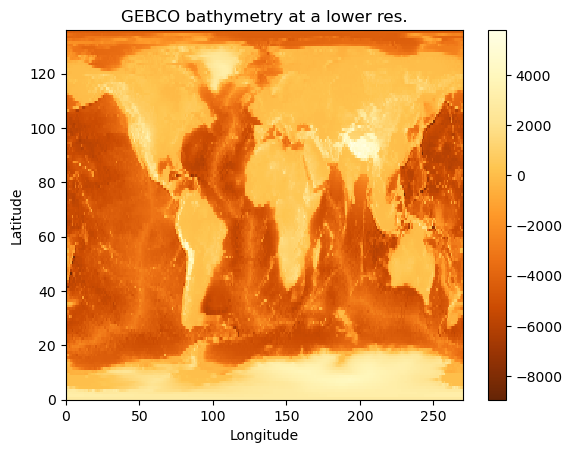

In [11]:
pcolormesh(transpose(b[1:10:end, 1:10:end]), cmap=PyPlot.cm.YlOrBr_r)
xlabel("Longitude")
ylabel("Latitude")
title("GEBCO bathymetry at a lower res.")
colorbar()
savefig("../Images/gebco_bathymetry")

## Write a netCDF
### Time series
Let's start with a very simple example: a temperature time series (1-dimensional dataset), corresponding to the mean temperature in Uccle, Belgium (source: [IRM](https://www.meteo.be/meteo/view/fr/360955-Normales+mensuelles.html#ppt_5238240)).

In [12]:
temperatureUccle = [3.3, 3.7, 6.8, 9.8, 13.6, 16.2, 18.4, 18., 14.9, 11.1, 6.8, 3.9];

In [13]:
length(temperatureUccle)

12

First, let's create the file (clobber mode indicated by **"c"**).    
Note that we need to ensure the file doesn't already exist (otherwise we remove it).

In [14]:
outputfile = "../data/temperature_belgium.nc"
if isfile(outputfile)
    rm(outputfile) 
    @info "Removing file $(outputfile)"
else
    @info "Creating a new netCDF"
end
ds = Dataset(outputfile, "c");

[ Info: Creating a new netCDF


Then we create a time dimension. Its size should match that of the temperature vector.

In [15]:
defDim(ds, "time", length(temperatureUccle))

Now we can also create the *temperature* variable, which has *time* as dimension.

In [16]:
temperature = defVar(ds, "temperature", Float64, ("time",));

We will fill this variable with the values previously defined (note again the `[:]`):

In [17]:
temperature[:] = temperatureUccle;

and don't forget to close the `ds`:

In [18]:
close(ds);

If you have [`ncdump`](https://www.unidata.ucar.edu/software/netcdf/netcdf-4/newdocs/netcdf/ncdump.html) available on your machine, you can easily check the file content:
```julia
run(`ncdump temperature_series.nc`)
```
Otherwise you can use the first part of the notebook, in which we've shown how to read a netCDF file.

## Exercice
Create a netCDF file storing a 2D field (it can be a random field or real data).     
The procedure is similar to the previous example, except that we will work with longitude and latitude dimensions, instead of time.

The solution is available in [03-netCDF-2Dimensions.ipynb](../Exercises/03-netCDF-2Dimensions.ipynb).